# Objective
This notebook aims to detect regime changes in the Indian equity market using a Hidden Markov Model (HMM). The analysis is based on Nifty 50 index data spanning from January 1, 2019 to December 30, 202, a period that includes the COVID-19 pandemic, which significantly impacted market dynamics. By modeling latent market states, the study seeks to identify and validate regime switches through both theoretical formulation and empirical inference using HMM.

**Hidden Markov Model**
HMM is a probabilistic model used to describe systems that evolve over time with hidden internal states and observable outputs. HMM is bifurcated, one observable component and another 'hidden' component that follows a Markov process. The observable output features a marginal distribution whose parameters change with the realization of an unobservable state.

$y_t = \mu_t+\epsilon_t$, where $\mu_t=\mu_i$ 

if $S_t=j$ & $S$={1,2,...N}, $S_t$ is Markovian and $ \epsilon_t$ is I.I.D ~ N(0,$\sigma^2$)

**Components of HMM**
* A set of M states $S$= {$s_1,s_2...s_N$}
Here in this notebook, I have considered three regimes as follows:

**Regime 0: Bull market (low volatility, +ve returns)**
  
**Regime 1: Bear market (high volatility, -ve returns)**

**Regime 2: Sideways market (moderate variance, low returns)**
 
* A transition probability matrix P
* A sequence of T,possibly vector-valued, observations $y_t$ = {$y_1,.....,y_t$}
* A sequence of observation marginal likelihoods $f(y_t|s_t=i)$ for each i=1,...N
* An initial probability distribution $\pi$= {$\pi_1,....\pi_N$
  }






# Assumption
An important assumption is that the hidden Markov process is independent of past observations:

$y_{t-1}$, i.e., $P${$s_t=j|s_t=i,y_{t-1}$} = $P${$s_t=j|s_t=i$} = $p_{ij}$

In [76]:
pip install ruptures

   ---------------------------------------- 0.0/473.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/473.1 kB ? eta -:--:--
    --------------------------------------- 10.2/473.1 kB ? eta -:--:--
    --------------------------------------- 10.2/473.1 kB ? eta -:--:--
   - ------------------------------------- 20.5/473.1 kB 131.3 kB/s eta 0:00:04
   -- ------------------------------------ 30.7/473.1 kB 163.8 kB/s eta 0:00:03
   --- ----------------------------------- 41.0/473.1 kB 196.9 kB/s eta 0:00:03
   ------- ------------------------------- 92.2/473.1 kB 374.1 kB/s eta 0:00:02
   ---------------------------------------  471.0/473.1 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 473.1/473.1 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
#import ruptures as rpt
from hmmlearn import hmm


In [4]:
# Define tickers
nifty_ticker = "^NSEI"
treasury_ticker = "^TNX"

# Define date range
start_date = "2019-01-01"
end_date = "2022-12-30"

# Download data
nifty_data = pd.DataFrame(yf.download(nifty_ticker, start=start_date, end=end_date))
nifty_data= nifty_data.reset_index()
nifty_data.columns = nifty_data.columns.droplevel(1)
nifty_data.columns.name = None
nifty_data['Close']=round(nifty_data['Close'],4)
nifty_all= nifty_data
nifty_data = nifty_data[['Date','Close']]
nifty_data = nifty_data.rename(columns={'Close': 'Nifty Close'})
nifty_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Nifty Close
0,2019-01-02,10792.5000
1,2019-01-03,10672.2500
2,2019-01-04,10727.3496
3,2019-01-07,10771.7998
4,2019-01-08,10802.1504


In [5]:
treasury_data = pd.DataFrame(yf.download(treasury_ticker, start=start_date, end=end_date))
treasury_data= treasury_data.reset_index()
treasury_data.columns = treasury_data.columns.droplevel(1)
treasury_data.columns.name = None
treasury_data['Close']=round(treasury_data['Close'],4)
treasury_all= treasury_data
treasury_data = treasury_data[['Date','Close']]
treasury_data = treasury_data.rename(columns={'Close': 'Treasury Close'})
treasury_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Treasury Close
0,2019-01-02,2.661
1,2019-01-03,2.554
2,2019-01-04,2.659
3,2019-01-07,2.682
4,2019-01-08,2.716


In [6]:
# Combine into one DataFrame
#combined_df = pd.DataFrame(pd.concat([nifty_data, treasury_data], axis=1))
combined_df = pd.merge(nifty_data, treasury_data, on='Date', how='inner')
# Display the head
combined_df.head()

,Date,Nifty Close,Treasury Close
0,2019-01-02,10792.5000,2.661
1,2019-01-03,10672.2500,2.554
2,2019-01-04,10727.3496,2.659
3,2019-01-07,10771.7998,2.682
4,2019-01-08,10802.1504,2.716


In [7]:
combined_df['Nifty_returns(%)']= combined_df['Nifty Close'].pct_change()*100
combined_df['Treasury_returns(%)']= combined_df['Treasury Close'].pct_change()*100
combined_df['Nifty_Volatility(%)'] = combined_df['Nifty_returns(%)'].rolling(window=7).std()*100
combined_df['Treasury_Volatility(%)'] = combined_df['Treasury_returns(%)'].rolling(window=7).std()*100
combined_df.head(10)

,Date,Nifty Close,Treasury Close,Nifty_returns(%),Treasury_returns(%),Nifty_Volatility(%),Treasury_Volatility(%)
0,2019-01-02,10792.5000,2.661,NaN,NaN,NaN,NaN
1,2019-01-03,10672.2500,2.554,-1.114200,-4.021045,NaN,NaN
2,2019-01-04,10727.3496,2.659,0.516289,4.111198,NaN,NaN
3,2019-01-07,10771.7998,2.682,0.414363,0.864987,NaN,NaN
4,2019-01-08,10802.1504,2.716,0.281760,1.267711,NaN,NaN
5,2019-01-09,10855.1504,2.728,0.490643,0.441826,NaN,NaN
6,2019-01-10,10821.5996,2.731,-0.309077,0.109971,NaN,NaN
7,2019-01-11,10794.9502,2.701,-0.246261,-1.098499,59.941968,246.436919
8,2019-01-14,10737.5996,2.710,-0.531272,0.333210,43.636903,161.178808
9,2019-01-15,10886.7998,2.711,1.389512,0.036900,65.114863,74.554957


# Visualizations
***Nifty***

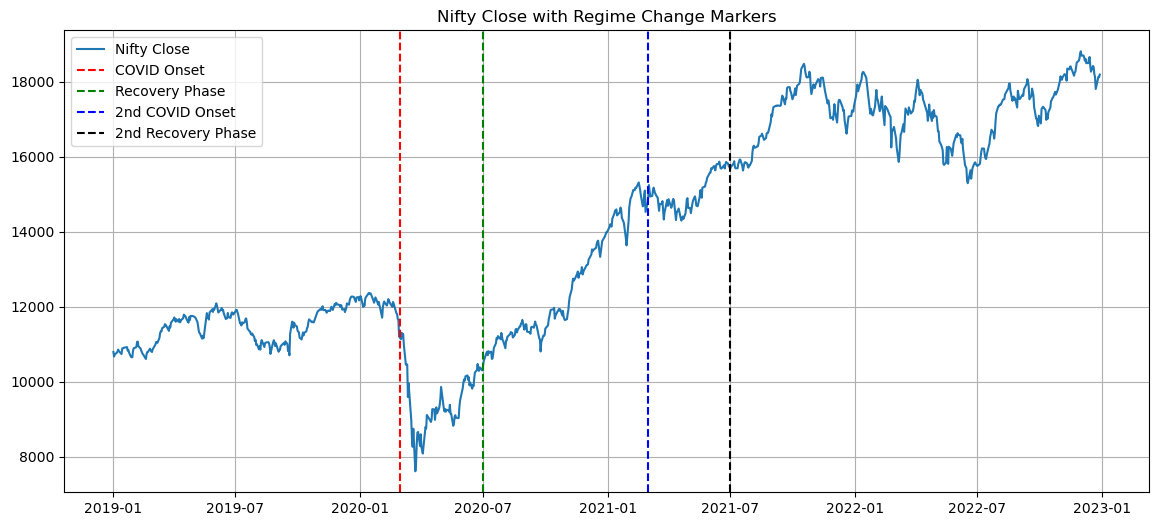

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['Nifty Close'], label='Nifty Close')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='COVID Onset')
plt.axvline(pd.to_datetime('2020-07-01'), color='green', linestyle='--', label='Recovery Phase')
plt.axvline(pd.to_datetime('2021-03-01'), color='blue', linestyle='--', label='2nd COVID Onset')
plt.axvline(pd.to_datetime('2021-07-01'), color='black', linestyle='--', label='2nd Recovery Phase')
plt.title("Nifty Close with Regime Change Markers")
plt.legend()
plt.grid(True)
plt.show()

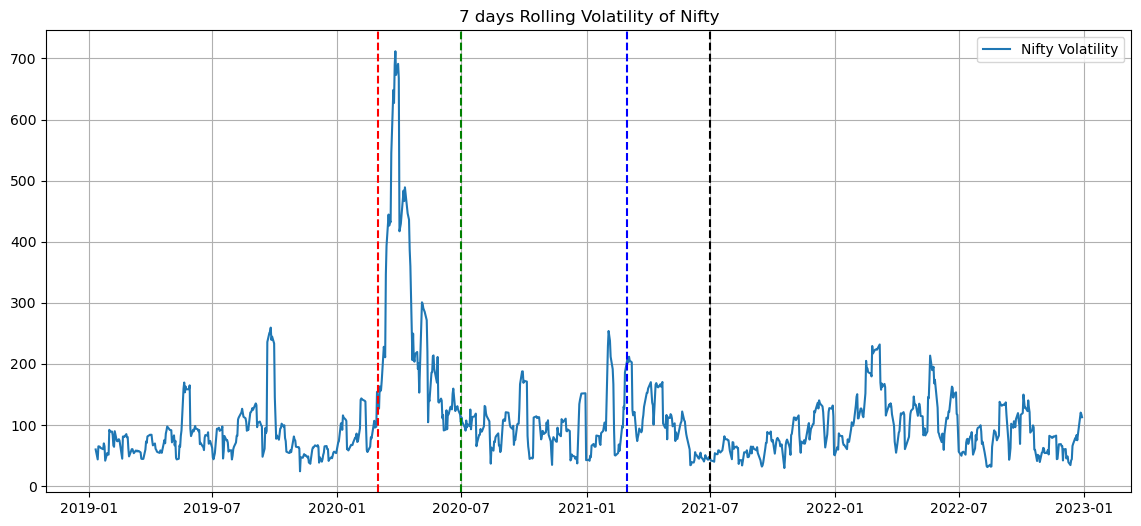

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['Nifty_Volatility(%)'], label='Nifty Volatility')
plt.title("7 days Rolling Volatility of Nifty")
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2020-07-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2021-03-01'), color='blue', linestyle='--')
plt.axvline(pd.to_datetime('2021-07-01'), color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

***Treasury***

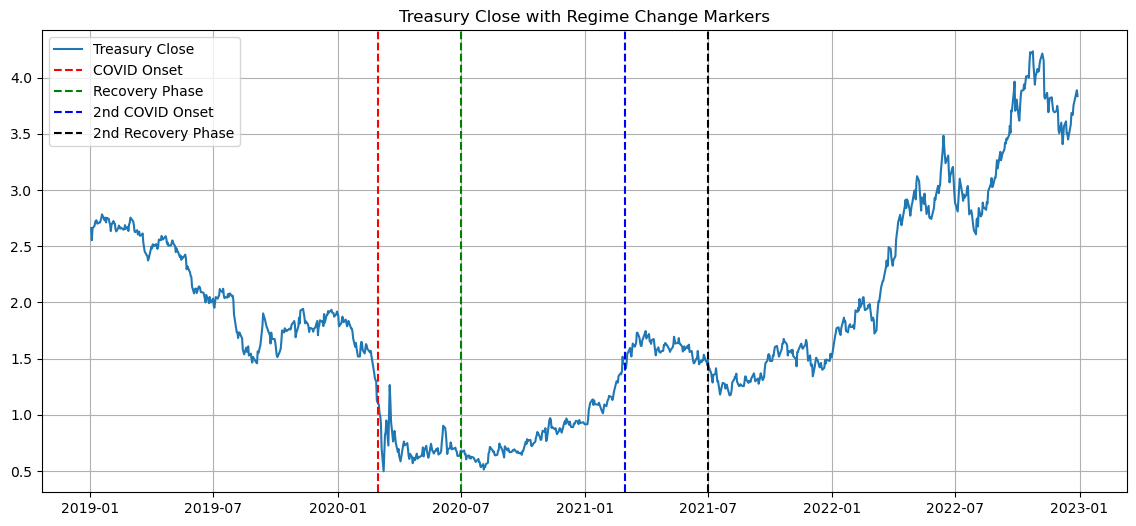

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['Treasury Close'], label='Treasury Close')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='COVID Onset')
plt.axvline(pd.to_datetime('2020-07-01'), color='green', linestyle='--', label='Recovery Phase')
plt.axvline(pd.to_datetime('2021-03-01'), color='blue', linestyle='--', label='2nd COVID Onset')
plt.axvline(pd.to_datetime('2021-07-01'), color='black', linestyle='--', label='2nd Recovery Phase')
plt.title("Treasury Close with Regime Change Markers")
plt.legend()
plt.grid(True)
plt.show()

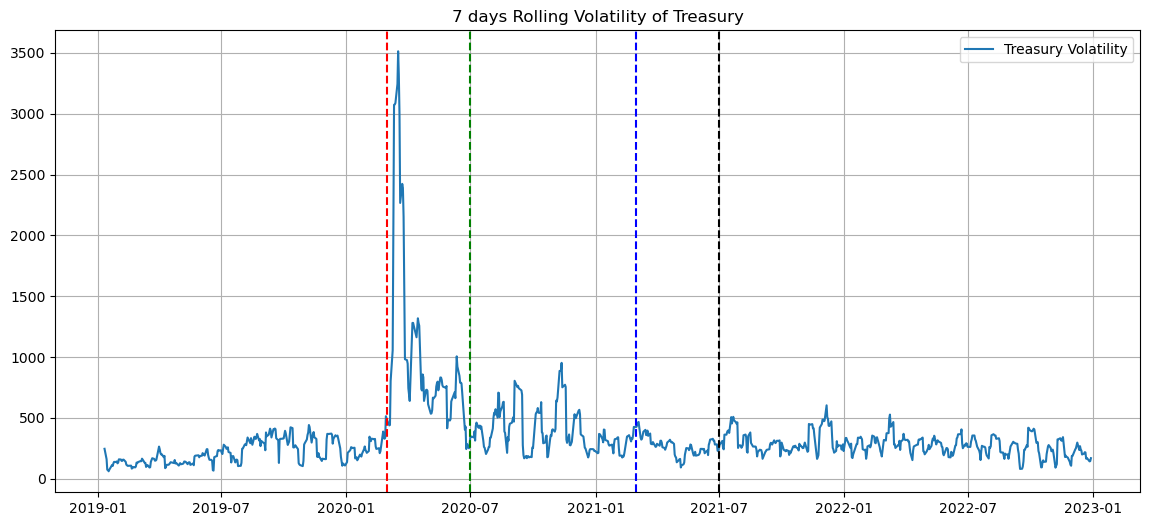

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['Treasury_Volatility(%)'], label='Treasury Volatility')
plt.title("7 days Rolling Volatility of Treasury")
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2020-07-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2021-03-01'), color='blue', linestyle='--')
plt.axvline(pd.to_datetime('2021-07-01'), color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

***Hidden Markov Model on Nifty***

In [12]:
# Create features
nifty_all['Log Return'] = np.log(nifty_all['Close'] / nifty_all['Close'].shift(1))
nifty_all['Range'] = nifty_all['High'] - nifty_all['Low']
# Drop missing values
features_df = nifty_all[['Date', 'Log Return', 'Range']].dropna()
X = features_df[['Log Return', 'Range']].values
dates = features_df['Date'].values

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


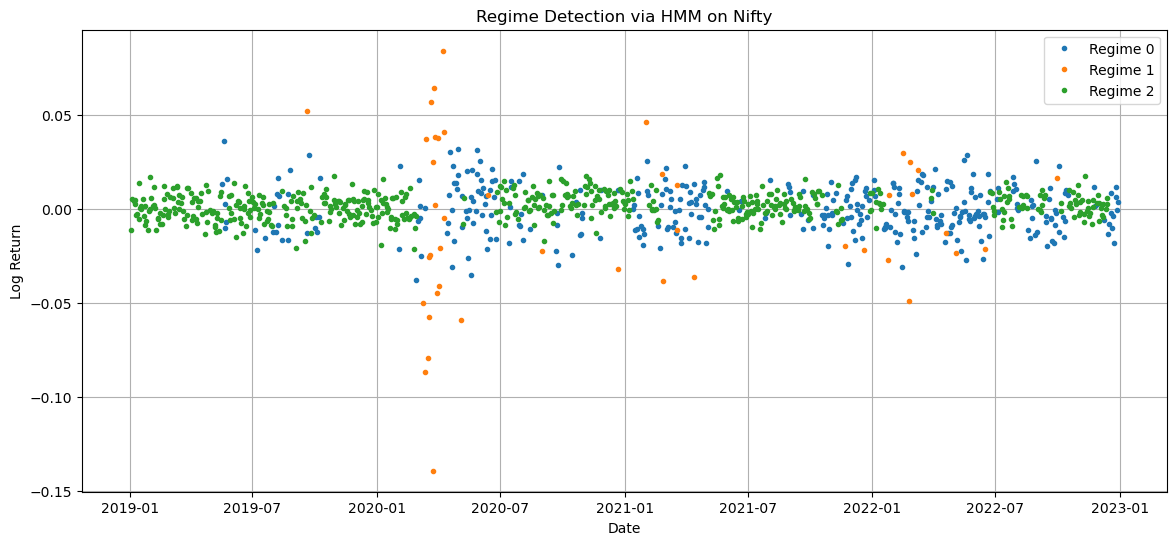

In [13]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
model.fit(X)
hidden_states = model.predict(X)

plt.figure(figsize=(14, 6))
for i in range(model.n_components):
    state = (hidden_states == i)
    plt.plot(dates[state], X[state, 0], '.', label=f'Regime {i}')  # Plot returns
plt.title("Regime Detection via HMM on Nifty")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

## Regime 0: Bull market (low volatility, +ve returns)
## Regime 1: Bear market (high volatility, -ve returns)
## Regime 2: Sideways market (moderate variance, low returns)

In [19]:
def compute_aic_bic(model, X):
    log_likelihood = model.score(X)
    n_params = model.n_components * (model.n_features + model.n_features * (model.n_features + 1) / 2) + \
               model.n_components - 1  # transition matrix params
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(len(X)) * n_params - 2 * log_likelihood
    return aic, bic

results = []
for n_states in [1,2,3]:
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(X)
    aic, bic = compute_aic_bic(model, X)
    results.append((n_states, aic, bic))

# Display results
for n_states, aic, bic in results:
    print(f"States: {n_states}, AIC: {aic:.2f}, BIC: {bic:.2f}")

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


States: 1, AIC: 6321.37, BIC: 6345.83
States: 2, AIC: 5147.64, BIC: 5201.45
States: 3, AIC: 4788.67, BIC: 4871.85


In [15]:
def plot_regimes(model, X, dates, title):
    hidden_states = model.predict(X)
    plt.figure(figsize=(14, 6))
    for i in range(model.n_components):
        state = (hidden_states == i)
        plt.plot(dates[state], X[state, 0], '.', label=f'Regime {i}')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


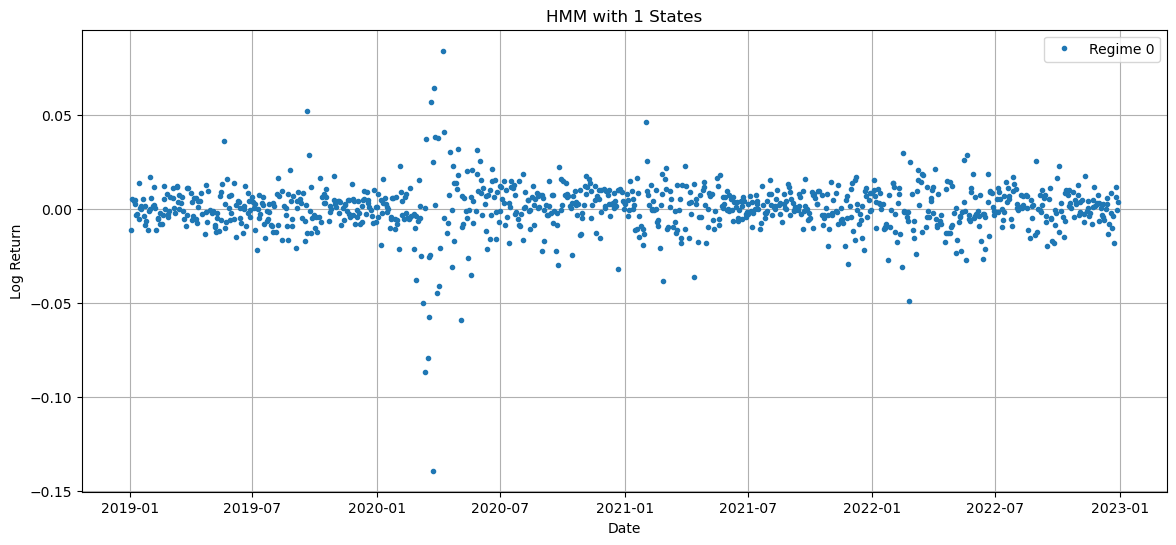

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


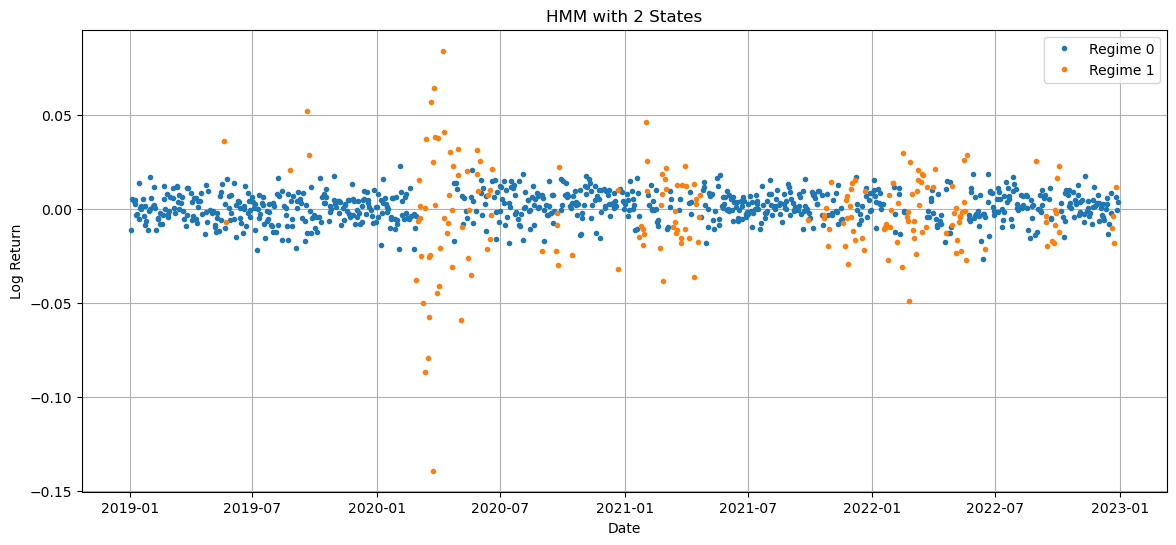

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


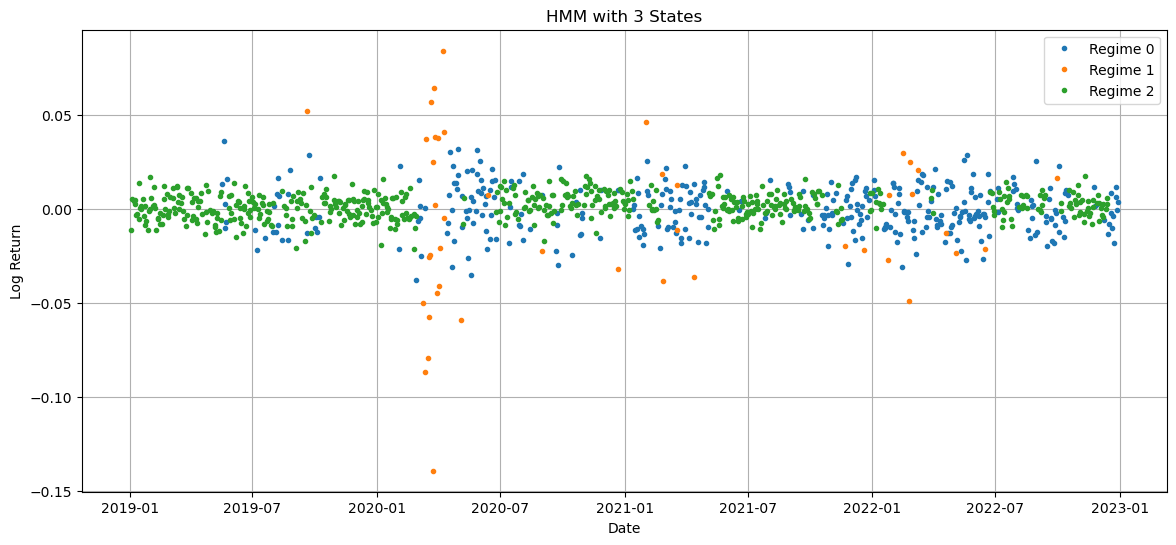

In [17]:
for n_states in [1,2,3]:
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(X)
    plot_regimes(model, X, dates, f"HMM with {n_states} States")

In [29]:
n_states = 3  # You can vary this
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
model.fit(X)

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


GaussianHMM(covariance_type='full', n_components=3, n_iter=1000,
            random_state=42)

In [30]:
range(n_states)

range(0, 3)

In [31]:
# Compute average covariance matrix across all states
avg_cov = np.mean(model.covars_, axis=0)

# Set all states to have the same covariance
model.covars_ = np.array([avg_cov for _ in range(n_states)])
model.covars_

array([[[7.01504257e-04, 2.92544279e-01],
        [2.92544279e-01, 1.67944539e+04]],

       [[7.01504257e-04, 2.92544279e-01],
        [2.92544279e-01, 1.67944539e+04]],

       [[7.01504257e-04, 2.92544279e-01],
        [2.92544279e-01, 1.67944539e+04]]])

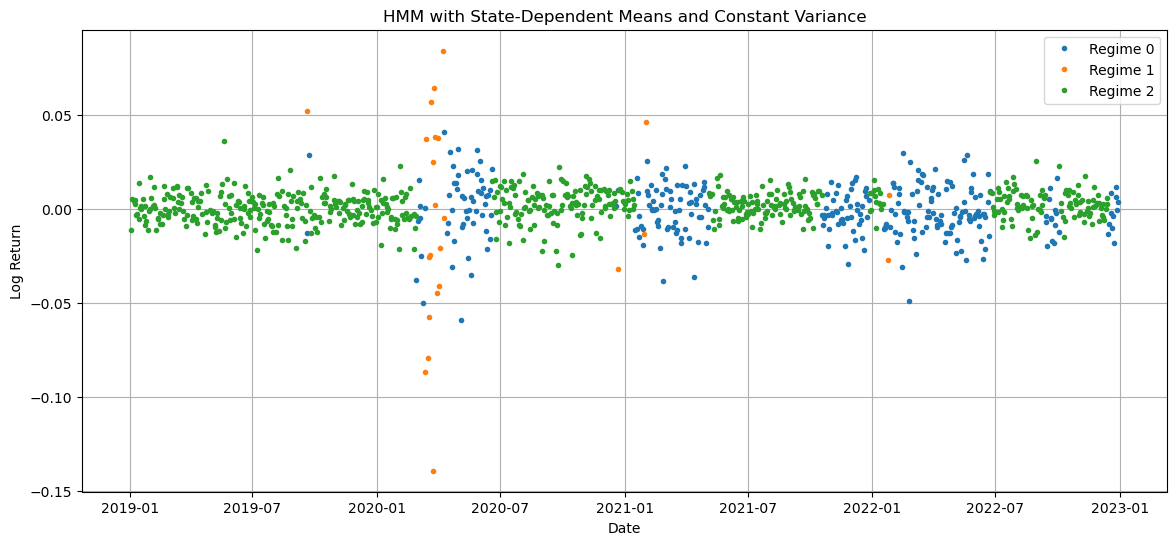

In [32]:
hidden_states = model.predict(X)

plt.figure(figsize=(14, 6))
for i in range(n_states):
    state = (hidden_states == i)
    plt.plot(dates[state], X[state, 0], '.', label=f'Regime {i}')
plt.title("HMM with State-Dependent Means and Constant Variance")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
for i in range(n_states):
    print(f"Regime {i}: Mean = {model.means_[i].flatten()[0]:.4f}")

Regime 0: Mean = -0.0003
Regime 1: Mean = -0.0065
Regime 2: Mean = 0.0017


In [38]:
def compute_aic_bic(model, X):
    log_likelihood = model.score(X)
    n_params = model.n_components * (model.n_features + model.n_features * (model.n_features + 1) / 2) + \
               model.n_components - 1  # transition matrix params
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(len(X)) * n_params - 2 * log_likelihood
    return aic, bic

results = []
for n_states in [1,2,3]:
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(X)
    aic, bic = compute_aic_bic(model, X)
    results.append((n_states, aic, bic))

# Display results
for n_states, aic, bic in results:
    print(f"States: {n_states}, AIC: {aic:.2f}, BIC: {bic:.2f}")

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


States: 1, AIC: 6321.37, BIC: 6345.83
States: 2, AIC: 5147.64, BIC: 5201.45
States: 3, AIC: 4788.67, BIC: 4871.85


***Hidden Markov Model on Treasury***

In [133]:
# Create features
treasury_all['Log Return'] = np.log(treasury_all['Close'] / treasury_all['Close'].shift(1))
treasury_all['Range'] = treasury_all['High'] - treasury_all['Low']
# Drop missing values
features_df_tr = treasury_all[['Date', 'Log Return', 'Range']].dropna()
X_tr = features_df_tr[['Log Return', 'Range']].values
dates_tr = features_df_tr['Date'].values

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4299.966393130402 is not greater than 4299.966501542064. Delta is -0.00010841166204045294


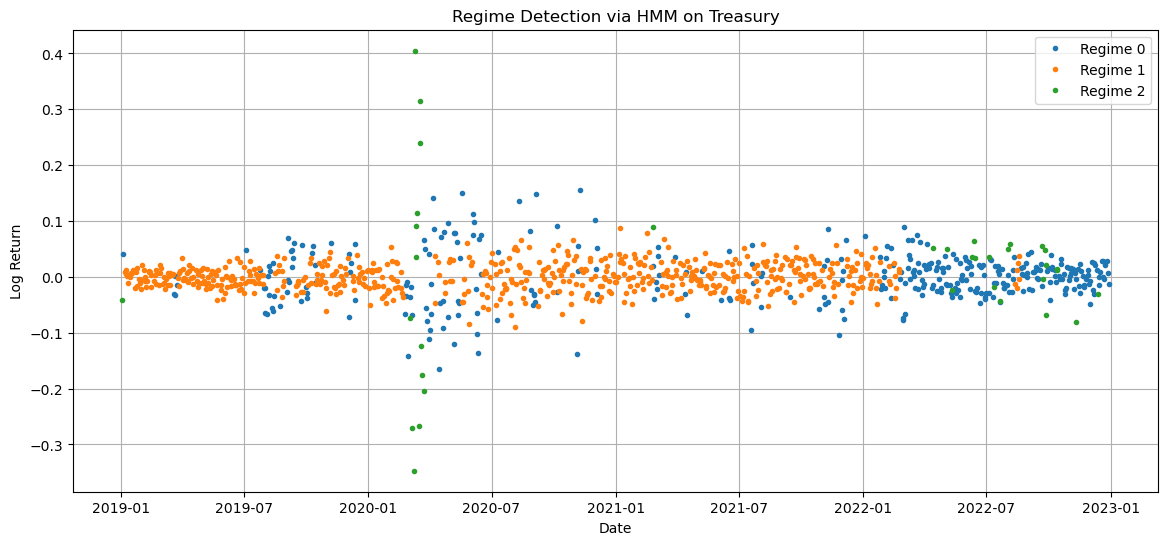

In [134]:
model_tr = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
model.fit(X_tr)
hidden_states = model.predict(X_tr)

plt.figure(figsize=(14, 6))
for i in range(model_tr.n_components):
    state = (hidden_states == i)
    plt.plot(dates_tr[state], X_tr[state, 0], '.', label=f'Regime {i}')  # Plot returns
plt.title("Regime Detection via HMM on Treasury")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

## Regime 0: Bull market (low volatility, +ve returns)
## Regime 1: Bear market (high volatility, -ve returns)
## Regime 2: Sideways market (moderate variance, low returns)